In [1]:
import glob 

import xarray
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from scipy.interpolate import RegularGridInterpolator


# Open the model file here.

In [2]:
file_pattern = '/home/svisaga/MUSICA_ANALYSES/curtain_tracks/p3_2019-*curtain*.nc'
file_list = glob.glob(file_pattern)

ds_mod = xarray.open_mfdataset(file_list,combine='by_coords')


In [3]:
ds_mod['datetime'].values

array(['2019-08-24 22:11:08', '2019-08-24 22:11:09',
       '2019-08-24 22:11:10', ..., '2019-10-05 07:29:22',
       '2019-10-05 07:29:23', '2019-10-05 07:29:24'], dtype=object)

In [4]:
ds_mod['datetime'] = pd.to_datetime(ds_mod['datetime'].values)


In [5]:
variables = ['alt_mod', 'EXTINCT_mod', 'pblh_mod']
ds_mod_ = ds_mod[variables]
df_mod = ds_mod_.to_dataframe().reset_index()
df_mod['datetime'] = pd.to_datetime(df_mod['datetime'])
df_mod = df_mod[(df_mod['datetime'] > '2019-09-15 21:56:00') & (df_mod['datetime'] < '2019-09-16 05:33:00')]



In [6]:
lev= 30
df_mod_alt_lev30 = df_mod.loc[df_mod['nl'] == (31 - lev), ['datetime', 'alt_mod']]
#df_mod_alt_lev30
ds_mod_alt_lev30 = df_mod_alt_lev30.set_index(['datetime']).to_xarray()


In [7]:
lev = 24
df_mod_alt_lev24 = df_mod.loc[df_mod['nl'] == (31 - lev), ['datetime', 'alt_mod']]
#df_mod_alt_lev24
ds_mod_alt_lev24 = df_mod_alt_lev24.set_index(['datetime']).to_xarray()

In [8]:
# We will use later for making xarray
df_mod_pblh = df_mod[['datetime','pblh_mod']].drop_duplicates()

# Open HSRL file.

In [9]:
dat = '20190915'
base_date = pd.Timestamp('2019-09-15')
ds = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/curtain_tracks/hsrl_{dat}_curtain_CAMP2Ex.nc')
ds = ds.assign_coords(Date=pd.to_datetime(ds['Date'].values))
ds

<xarray.Dataset>
Dimensions:       (Date: 2721, Altitude: 521)
Coordinates:
  * Date          (Date) datetime64[ns] 2019-09-15T21:56:06 ... 2019-09-16T05...
  * Altitude      (Altitude) float64 -500.0 -485.0 -470.0 ... 7.28e+03 7.295e+03
Data variables:
    hsrl_532_ext  (Date, Altitude) float64 ...

In [10]:
kk = 630
ee = 820

# pblh xarray

In [11]:
ds_mod_pblh_interp = df_mod_pblh.set_index(['datetime']).to_xarray()



# Start interpolating MUSICAv0 Extinction to HSRL altitude values.

In [12]:
constant_altitudes = ds.Altitude.values

# Create an empty DataFrame to store the resampled data
df_mod_interp = []

# Group the data by datetime
grouped = df_mod.groupby('datetime')

for name, group in grouped:
    # Sort by altitude to ensure monotonic input for interpolation
    group_sorted = group.sort_values('alt_mod')

    # Get min and max altitude for this group
    min_alt = group_sorted['alt_mod'].min()
    max_alt = group_sorted['alt_mod'].max()

    # Clip constant_altitudes to the valid range
    valid_altitudes = constant_altitudes[
        (constant_altitudes >= min_alt) & (constant_altitudes <= max_alt)
    ]

    # Interpolate only within the valid range
    interpolated = np.interp(valid_altitudes, group_sorted['alt_mod'], group_sorted['EXTINCT_mod'])

    # Create a DataFrame for the interpolated data
    interpolated_df = pd.DataFrame({
        'datetime': name,
        'altitude': valid_altitudes,
        'EXTINCT_mod': interpolated
    })

    df_mod_interp.append(interpolated_df)

df_mod_interp = pd.concat(df_mod_interp, ignore_index=True)
df_mod_interp


,datetime,altitude,EXTINCT_mod
0,2019-09-15 21:56:01,234.491522,NaN
1,2019-09-15 21:56:01,249.481145,NaN
2,2019-09-15 21:56:01,264.470768,NaN
3,2019-09-15 21:56:01,279.460391,NaN
4,2019-09-15 21:56:01,294.450014,NaN
...,...,...,...
13203186,2019-09-16 05:32:59,7234.645416,8.114068e-07
13203187,2019-09-16 05:32:59,7249.635039,8.087478e-07
13203188,2019-09-16 05:32:59,7264.624662,8.060887e-07
13203189,2019-09-16 05:32:59,7279.614285,8.034297e-07


# Make df_mod interpolated to HSRL altitude to a Data Array.

In [13]:
ds_mod_interp = df_mod_interp.set_index(['datetime', 'altitude']).to_xarray()
ds_mod_interp


<xarray.Dataset>
Dimensions:      (datetime: 27419, altitude: 483)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2019-09-15T21:56:01 ... 2019-09-16...
  * altitude     (altitude) float64 69.61 84.6 99.58 ... 7.28e+03 7.295e+03
Data variables:
    EXTINCT_mod  (datetime, altitude) float64 nan nan ... 8.034e-07 8.008e-07

# Visualize the interpolated Extinction.

In [14]:
curt_time = ds_mod_interp['datetime']
curt_time_np = np.array(curt_time, dtype='datetime64')

# Create a 2D array by repeating curt_time_np along the second axis
curt_time2 = np.tile(curt_time_np[:, np.newaxis], (1, ds_mod_interp['EXTINCT_mod'].shape[1]))


In [15]:
ds_mod_alt_lev24

<xarray.Dataset>
Dimensions:   (datetime: 27419)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2019-09-15T21:56:01 ... 2019-09-16T05...
Data variables:
    alt_mod   (datetime) float64 1.892e+03 1.892e+03 ... 1.779e+03 1.779e+03

In [16]:
startdate_ = '2019-09-15 23:41:00'
enddate_ = '2019-09-16 00:13:00'
filedate_ = '0915_2341'
ds_mod_interp_ = ds_mod_interp.sel(datetime=slice(startdate_, enddate_))
ds_mod_interp_

ds_mod_alt_lev24_ = ds_mod_alt_lev24.sel(datetime=slice(startdate_, enddate_))
ds_mod_alt_lev30_ = ds_mod_alt_lev30.sel(datetime=slice(startdate_, enddate_))
ds_mod_pblh_interp_ = ds_mod_pblh_interp.sel(datetime=slice(startdate_, enddate_))

# Use longitude values for x-axis.

In [17]:
ds_nav = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/CAMP2EX-HSRL2_P3B_{dat}_R0.h5', engine='h5netcdf', 
                             phony_dims='access', group='Nav_Data')

base_jday = ds_nav['Jday'][:,0].values[0]

# Calculate the difference in days from the base Julian Day
day_deltas = ds_nav['Jday'][:,0].values - base_jday

# Convert GPS times in hours to timedeltas
time_deltas = pd.to_timedelta(ds_nav['gps_time'][:,0].values, unit='h')

# Create datetime objects by adding the day deltas to the base date
dates = base_date + pd.to_timedelta(day_deltas, unit='D')

# Add the time deltas to the dates
date_times = dates + time_deltas

# Format the dates to YY-MM-DD
formatted_dates = date_times.strftime('%Y-%m-%d %H:%M:%S')


# Create a new xarray DataArray
ds_nav['Date'] = xarray.DataArray(
    formatted_dates,
    dims=["time"]
)



In [18]:
df_nav = ds_nav['Date'].to_dataframe().reset_index()
df_nav['time'] = pd.to_datetime(df_nav['time'])

In [19]:
dat = '20190915'
dat1 = '2019-09-15-03600'
dat2 = '2019-09-16-03600'
workdir = '/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/'
p3file = f'CAMP2Ex-mrg01-P3B-NC_merge_{dat}_R3.nc'
p3data_ds = xarray.open_dataset(workdir+p3file)

variables = ['AOT532_hi']
selected_data = p3data_ds[variables]
p3data = selected_data.to_dataframe().reset_index()
p3data['time'] = pd.to_datetime(p3data['time'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [20]:
df_nav_ = pd.merge(df_nav, p3data, on='time', how='inner')
df_nav_

,time,Date,AOT532_hi,lat,lon,alt
0,2019-09-15 21:56:06,2019-09-15 21:56:06,NaN,15.177249,120.559052,180.100006
1,2019-09-15 21:56:16,2019-09-15 21:56:16,NaN,15.170413,120.556412,225.899994
2,2019-09-15 21:56:26,2019-09-15 21:56:26,NaN,15.163334,120.553856,272.399994
3,2019-09-15 21:56:36,2019-09-15 21:56:36,NaN,15.156045,120.551460,326.000000
4,2019-09-15 21:56:46,2019-09-15 21:56:46,NaN,15.148691,120.549034,382.299988
...,...,...,...,...,...,...
2716,2019-09-16 05:32:18,2019-09-16 05:32:18,NaN,15.079492,120.751846,1627.400024
2717,2019-09-16 05:32:28,2019-09-16 05:32:28,NaN,15.090205,120.750603,1613.900024
2718,2019-09-16 05:32:38,2019-09-16 05:32:38,NaN,15.101133,120.749268,1610.099976
2719,2019-09-16 05:32:48,2019-09-16 05:32:48,NaN,15.112211,120.747917,1613.599976


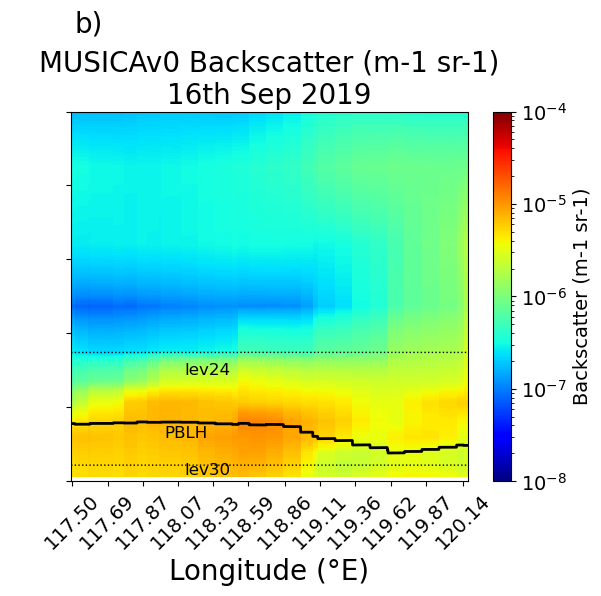

In [36]:
date_index = pd.DatetimeIndex(ds_nav['Date'][kk:ee].values)
lon_vals = df_nav_['lon'].values[kk:ee]

fig, ax = plt.subplots()
c = ax.pcolormesh(ds_mod_interp_['datetime'],ds_mod_interp_['altitude']/1000,(ds_mod_interp_['EXTINCT_mod']/60).T,norm=mcolors.LogNorm(vmin=1E-8, vmax=1E-4),cmap='jet')
ax.text(0.01, 1.2, f'b)', transform=ax.transAxes,
            fontsize=20,  va='bottom', ha='left')

# Plot MLH on top
ax.plot(ds_mod_pblh_interp_['datetime'], ds_mod_pblh_interp_['pblh_mod']/1000, color='black', linewidth=2, label='MLH')
ax.plot(ds_mod_alt_lev24_['datetime'], ds_mod_alt_lev24_['alt_mod']/1000, color='black', linestyle=':', linewidth=1, label='lev24')
ax.plot(ds_mod_alt_lev30_['datetime'], ds_mod_alt_lev30_['alt_mod']/1000, color='black', linestyle=':', linewidth=1, label='lev30')

ax.set_ylim(0,5)
# Replace major ticks with longitude values
tick_indices = np.linspace(0, len(date_index) - 1, num=12, dtype=int)  # Adjust num for desired tick count
tick_positions = date_index[tick_indices]
tick_labels = [f"{lon_vals[i]:.2f}" for i in tick_indices]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, fontsize=14)
ax.set_xlabel('Longitude (°)', fontsize=20)


x_last = ds_mod_alt_lev24_['datetime'].values[550]
ax.text(x_last, 1.5, 'lev24', color='k', fontsize=12, ha='left', va='center')
x_last = ds_mod_alt_lev24_['datetime'].values[450]
ax.text(x_last, 0.65, 'PBLH', color='k', fontsize=12, ha='left', va='center')

x_last = ds_mod_alt_lev30_['datetime'].values[550]
ax.text(x_last, 0.15, 'lev30', color='k', fontsize=12, ha='left', va='center')
plt.yticks(fontsize=20, color='white')

cbar = plt.colorbar(c)
cbar.set_label('Backscatter (m-1 sr-1)', fontsize=14)
cbar.ax.tick_params(labelsize=14)      

plt.title(f'MUSICAv0 Backscatter (m-1 sr-1)\n16th Sep 2019',fontsize=20)
plt.ylabel('Altitude (km)',fontsize=20, color='white')
plt.xlabel('Longitude (°E)',fontsize=20)
plt.savefig(f'img/Figure8b_AMSPaper.png',dpi=300, bbox_inches='tight')